# Aruco marker recognition
### Get in touch with aruco library
First use aruco library functions to detect markers in images.\
Markers are printed in A4 sheets, photos are taken by phone. Camera calibration is not needed for this first part.

In [1]:
# Import libraries once
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt

# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_5X5_50)

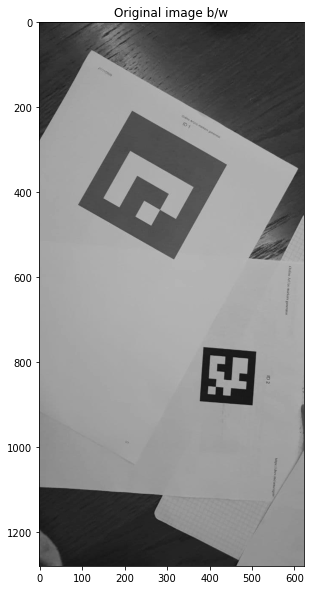

ID: [2]; Corners: [[[509. 775.]
  [500. 901.]
  [377. 891.]
  [385. 765.]]]


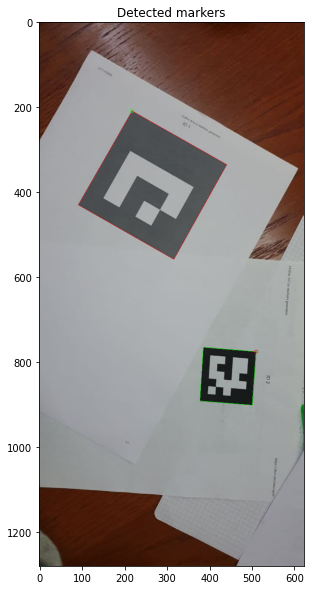

In [2]:
# Read the image with the markers
queryImg = cv2.imread("test-imgs/two-aruco-types.jpg")

# grayscale image
grayQueryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,10))
plt.imshow(grayQueryImg, cmap='gray', vmin=0, vmax=255)
plt.title("Original image b/w")
plt.show()

#======== Detect Aruco markers ========
corners, ids, rejectedImgPoints = aruco.detectMarkers(queryImg, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
# For each marker found is returned
# - list of 4 corners in clockwise order from top-left one
# - the list of ids of each of the detected markers in markerCorners

# Check if at least one marker has been found
if ids is not None and len(ids) >= 1:
    # Print corners and ids to the console
    for i, corner in zip(ids, corners):
        print('ID: {}; Corners: {}'.format(i, corner))

    # Outline all of the markers detected in the image
    # Draw a green contour around the valid markers
    detectedArucoImg = aruco.drawDetectedMarkers(queryImg, corners, borderColor=(0, 255, 0))
    
    # Draw a red contour around discarded markers
    if rejectedImgPoints is not None and len(rejectedImgPoints) >= 1:
        detectedArucoImg = aruco.drawDetectedMarkers(detectedArucoImg, rejectedImgPoints, borderColor=(0, 0, 255))

    # Display result
    cv2.imshow('Detected markers', detectedArucoImg)
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(detectedArucoImg, cv2.COLOR_BGR2RGB))
    plt.title("Detected markers")
    plt.show()
    
    cv2.waitKey(0)
else:
    print("No marker detected!")
    print("Rejected points:", rejectedImgPoints)

cv2.destroyAllWindows()

In previous code all worked as expected. The biggest aruco was not recognise because is from 4x4 dictionary, not 5x5 as the second one.

Just an utility function for closing windows

In [3]:
cv2.destroyAllWindows()

### Edit aruco markers
Delete the arucos found in the image and write their ID

In [4]:
# Given the aruco id and corners, draw a polygon on the marker and write its ID
def IDoverAruco(ids, corners, grayQueryImg):
    font = cv2.FONT_HERSHEY_SIMPLEX

    arucoIDImg = np.copy(grayQueryImg)
    # Check if some aruco has been found
    if ids is not None and len(ids) >= 1:
        for i, corner in zip(ids, corners):
            #print("Corners:", corner)
            cv2.fillPoly(arucoIDImg, corner.astype(int), (230, 230, 230))

            center = np.abs(corner[0][0] + corner[0][2]) / 2
            textX, textY = center
            textsizeX, textsizeY = cv2.getTextSize(str(i[0]), font, 1, 3)[0]
            textX = (textX - textsizeX / 2).astype(int)
            textY = (textY + textsizeY / 2).astype(int)
            cv2.putText(arucoIDImg, str(i[0]), (textX, textY), font, 1, (0, 0, 0), 2)

    return arucoIDImg

In [5]:
# Open the image given a path and find aruco markers
def findAruco(imgPath, ARUCO_DICT, ARUCO_PARAMETERS):
    # Read the image with the markers
    img = cv2.imread(imgPath)

    # grayscale image
    #img_bw = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
    
    #======== Detect Aruco markers ========
    corners, ids, _ = aruco.detectMarkers(img, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
    
    return img, ids, corners 

Given the previous two functions, implement the code to check if working.\
Apply on two images.

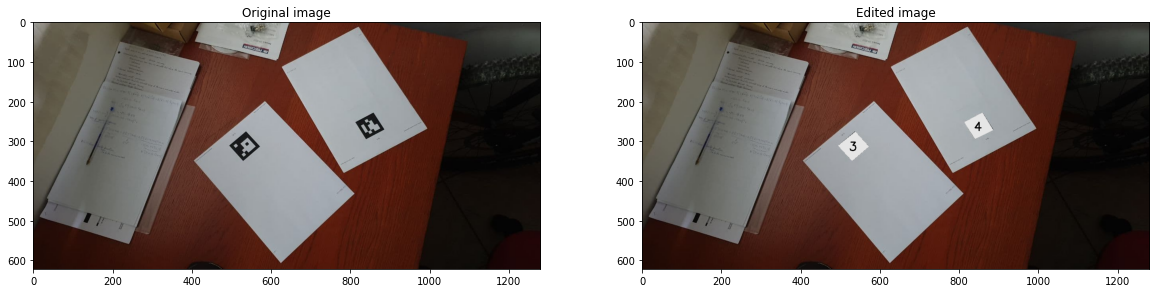

Found 2 aruco in image


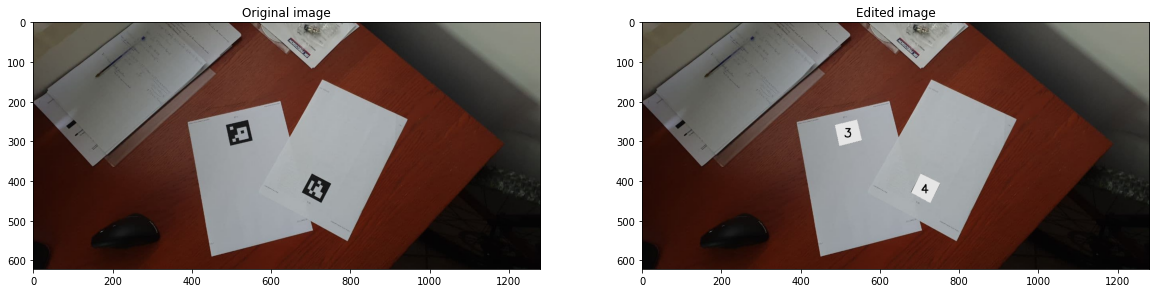

Found 2 aruco in image


In [6]:
# Pass path to function and get original image, edited one and number of found aruco
img, ids, corners = findAruco("test-imgs/two-A4-splitted.jpg", ARUCO_DICT, ARUCO_PARAMETERS)
img_edited = IDoverAruco(ids, corners, img)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_edited, cv2.COLOR_BGR2RGB))
plt.title("Edited image")
plt.show()

print("Found {} aruco in image".format(len(ids)))

# Second image
img2, ids2, corners2 = findAruco("test-imgs/two-A4-merged.jpg", ARUCO_DICT, ARUCO_PARAMETERS)
img_edited2 = IDoverAruco(ids2, corners2, img2)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_edited2, cv2.COLOR_BGR2RGB))
plt.title("Edited image")
plt.show()

print("Found {} aruco in image".format(len(ids2)))

### Identify the rectangle in witch the aruco is included
The aruco would be in white rectangle containing the switches.\
Once found the area, we should restict the search of switches in this area.\
The following code is structured as:
1. Find rectangular contours in image (discarding those with very small area);
2. Discard contours that do not contain a marker;
3. Select the contour with smaller area. It is possible that multiple contours contains the aruco, we need the nearest aka smallest one.

In [7]:
# Return: array with selected contours, None if no markers are provided
def findRectangles(imgRect, idsR, cornersR):
    debug = 0
    # Grayscale image is requested for contour recognition
    imgRectGray = cv2.cvtColor(imgRect, cv2.COLOR_BGR2GRAY)

    # Check if at least one marker has been found
    if idsR is None or len(idsR) == 0:
        # If no marker detected, exit
        print("No marker detected!")
        return None

    # Print found arucos
    if debug:
        for i, corner in zip(idsR, cornersR):
            print('Detected aruco with ID: {}.'.format(i[0]))

    #======== Find contours in image ========
        
    # The "findContours" function nedd a binary image, so need to threeshold before
    ret, img_thresh = cv2.threshold(imgRectGray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Identify rectangular contours
    rect_cnts = []
    areas = []
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
        (x, y, w, h) = cv2.boundingRect(cnt)
        #ar = w / float(h)
        if len(approx) == 4: # shape filtering condition
            # Get the area of the rectangle, need to exclude rectangles with area less than the 
            # one of the smallest aruco
            area = cv2.contourArea(cnt)

            # Exclude rectangles with pixel area, due to some threesholding error perhaps
            if area >= 5.0:
                areas.append(area)
                rect_cnts.append(cnt) # Shape is rectangle, add to the valid list
    # Now in rect_cnts[] we have only rectangular contours

    #======== Discard the contours that do not contain any aruco (multiple markers can be present in the image)

    # Make a copy to preserve the original image, draw functions are destructive
    imgRectDraw = np.copy(imgRect)

    j = 0
    in_cnt = []
    for aruco_n, corner_n in zip(idsR, cornersR): # for every aruco marker in image...
        cnt_father = []
        corner_n = corner_n[0] # adjust array dimensionality
        for cnt in rect_cnts: # for every rectangular contour...
            dist = cv2.pointPolygonTest(cnt, (corner_n[0][0].astype(int), corner_n[0][1].astype(int)), True) # Check if top left corner of the aruco
            if dist > 1.: # if the aruco is inside the contour...
                cnt_father.append(cnt) # add the contour in list
                if debug:
                    cv2.drawContours(imgRectDraw, [cnt], -1, (0,255,0), 2) # for debug draw the contour found
        if len(cnt_father) != 0:
            in_cnt.append(cnt_father) # check next aruco
        
    if debug:
        #cv2.imshow('Aruco Containers', imgRectDraw)

        plt.figure(figsize=(20,10))

        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(imgRect, cv2.COLOR_BGR2RGB))
        plt.title("Original image")

        plt.subplot(1,2,2)
        plt.imshow(cv2.cvtColor(imgRectDraw, cv2.COLOR_BGR2RGB))
        plt.title("Aruco containers")
        plt.show()

        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return in_cnt

Found 2 aruco and 2 rectangles.


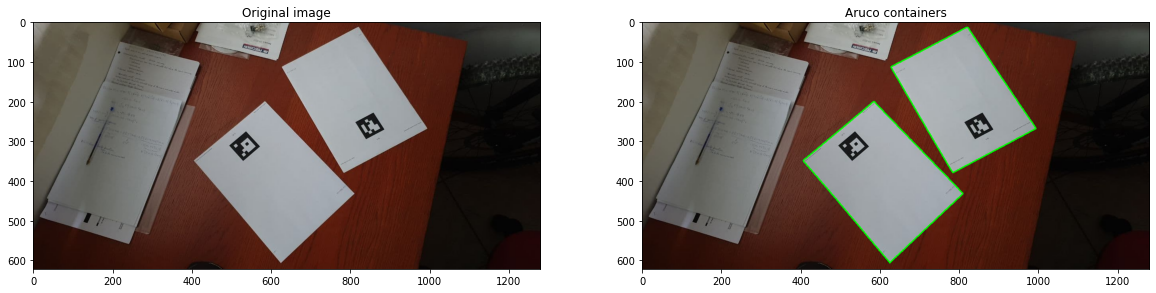

In [8]:
# Read the image and get all the aruco corners
imgRect, idsR, cornersR = findAruco("test-imgs/two-A4-splitted.jpg", ARUCO_DICT, ARUCO_PARAMETERS)

rects = findRectangles(imgRect, idsR, cornersR)

print("Found {} aruco and {} rectangles.".format(len(idsR), len(rects)))

imgRectDraw = np.copy(imgRect)
if len(rects) > 0: 
    for rect in rects:
        cv2.drawContours(imgRectDraw, [rect[0]], -1, (0,255,0), 2)
else:
    print("No containers found!")
    
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imgRect, cv2.COLOR_BGR2RGB))
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgRectDraw, cv2.COLOR_BGR2RGB))
plt.title("Aruco containers")
plt.show()

Found 2 aruco and 0 rectangles.
No containers found!


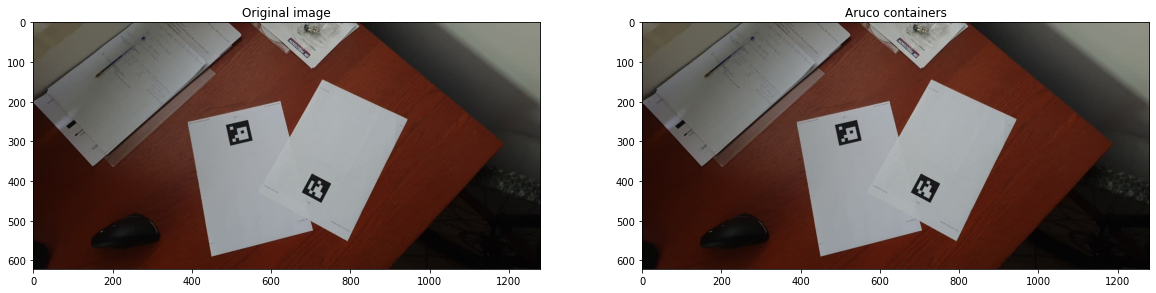

In [9]:
# Read the image and get all the aruco corners
imgRect, idsR, cornersR = findAruco("test-imgs/two-A4-merged.jpg", ARUCO_DICT, ARUCO_PARAMETERS)

rects = findRectangles(imgRect, idsR, cornersR)

print("Found {} aruco and {} rectangles.".format(len(idsR), len(rects)))

imgRectDraw = np.copy(imgRect)
if len(rects) > 0: 
    for rect in rects:
        cv2.drawContours(imgRectDraw, [rect[0]], -1, (0,255,0), 2)
else:
    print("No containers found!")
    
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imgRect, cv2.COLOR_BGR2RGB))
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgRectDraw, cv2.COLOR_BGR2RGB))
plt.title("Aruco containers")
plt.show()

Found 1 aruco and 1 rectangles.


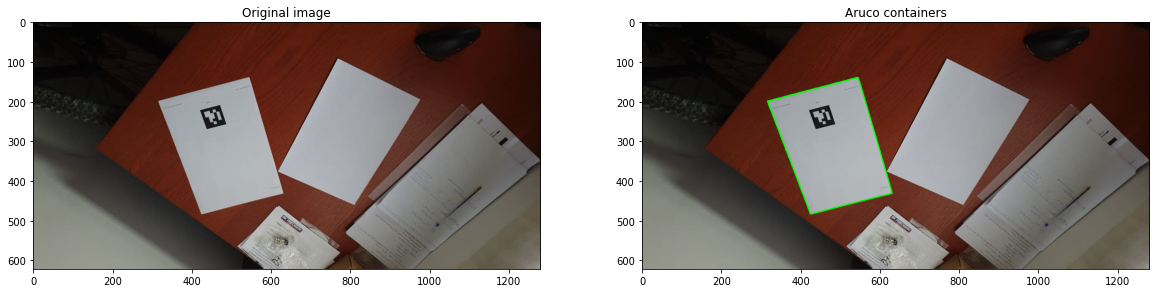

In [10]:
# Read the image and get all the aruco corners
imgRect, idsR, cornersR = findAruco("test-imgs/two-A4-blank.jpg", ARUCO_DICT, ARUCO_PARAMETERS)

rects = findRectangles(imgRect, idsR, cornersR)

print("Found {} aruco and {} rectangles.".format(len(idsR), len(rects)))

imgRectDraw = np.copy(imgRect)
if len(rects) > 0: 
    for rect in rects:
        cv2.drawContours(imgRectDraw, [rect[0]], -1, (0,255,0), 2)
else:
    print("No containers found!")
    
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imgRect, cv2.COLOR_BGR2RGB))
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgRectDraw, cv2.COLOR_BGR2RGB))
plt.title("Aruco containers")
plt.show()

Once got all the rectangles, we can do step 3) that is select only the nearest one wrt the marker

Found 1 aruco and 1 rectangles.


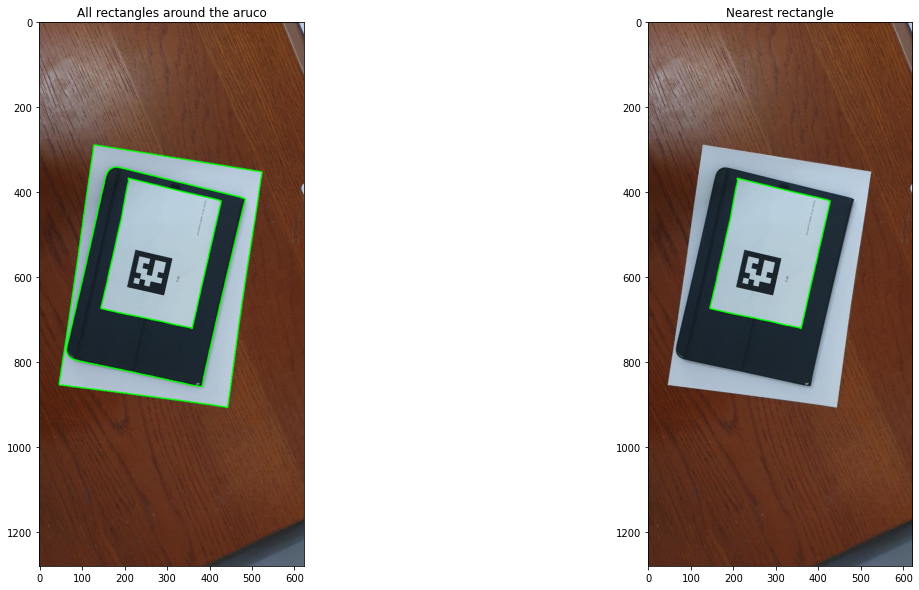

In [15]:
# Read the image and get all the aruco corners
imgRect, idsR, cornersR = findAruco("test-imgs/double-rectangle.jpg", ARUCO_DICT, ARUCO_PARAMETERS)

rects = findRectangles(imgRect, idsR, cornersR)

print("Found {} aruco and {} rectangles.".format(len(idsR), len(rects)))

imgRectAll = np.copy(imgRect) # All rectangles around the marker
imgRectMin = np.copy(imgRect) # Only smallest one
if len(rects) > 0: 
    for rect in rects: # for every aruco in image...
        areas = np.array(list(map(cv2.contourArea, rect))) # compute the area of the contour
        
        min_area_n = np.argmin(areas) # find array num of the smallest area
        cv2.drawContours(imgRectMin, [rect[min_area_n]], -1, (0,255,0), 2) # draw the contour of only the smallest
        
        for cnt in rect:
            cv2.drawContours(imgRectAll, [cnt], -1, (0,255,0), 2) # draw all the contours
else:
    print("No containers found!")
    
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imgRectAll, cv2.COLOR_BGR2RGB))
plt.title("All rectangles around the aruco")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgRectMin, cv2.COLOR_BGR2RGB))
plt.title("Nearest rectangle")
plt.show()